# "Unwrapping" the bark of a tree scanned using the free app [scaniverse](https://scaniverse.com/)
3D scan exported as an STL file and converted into a point cloud using Open3D in Python

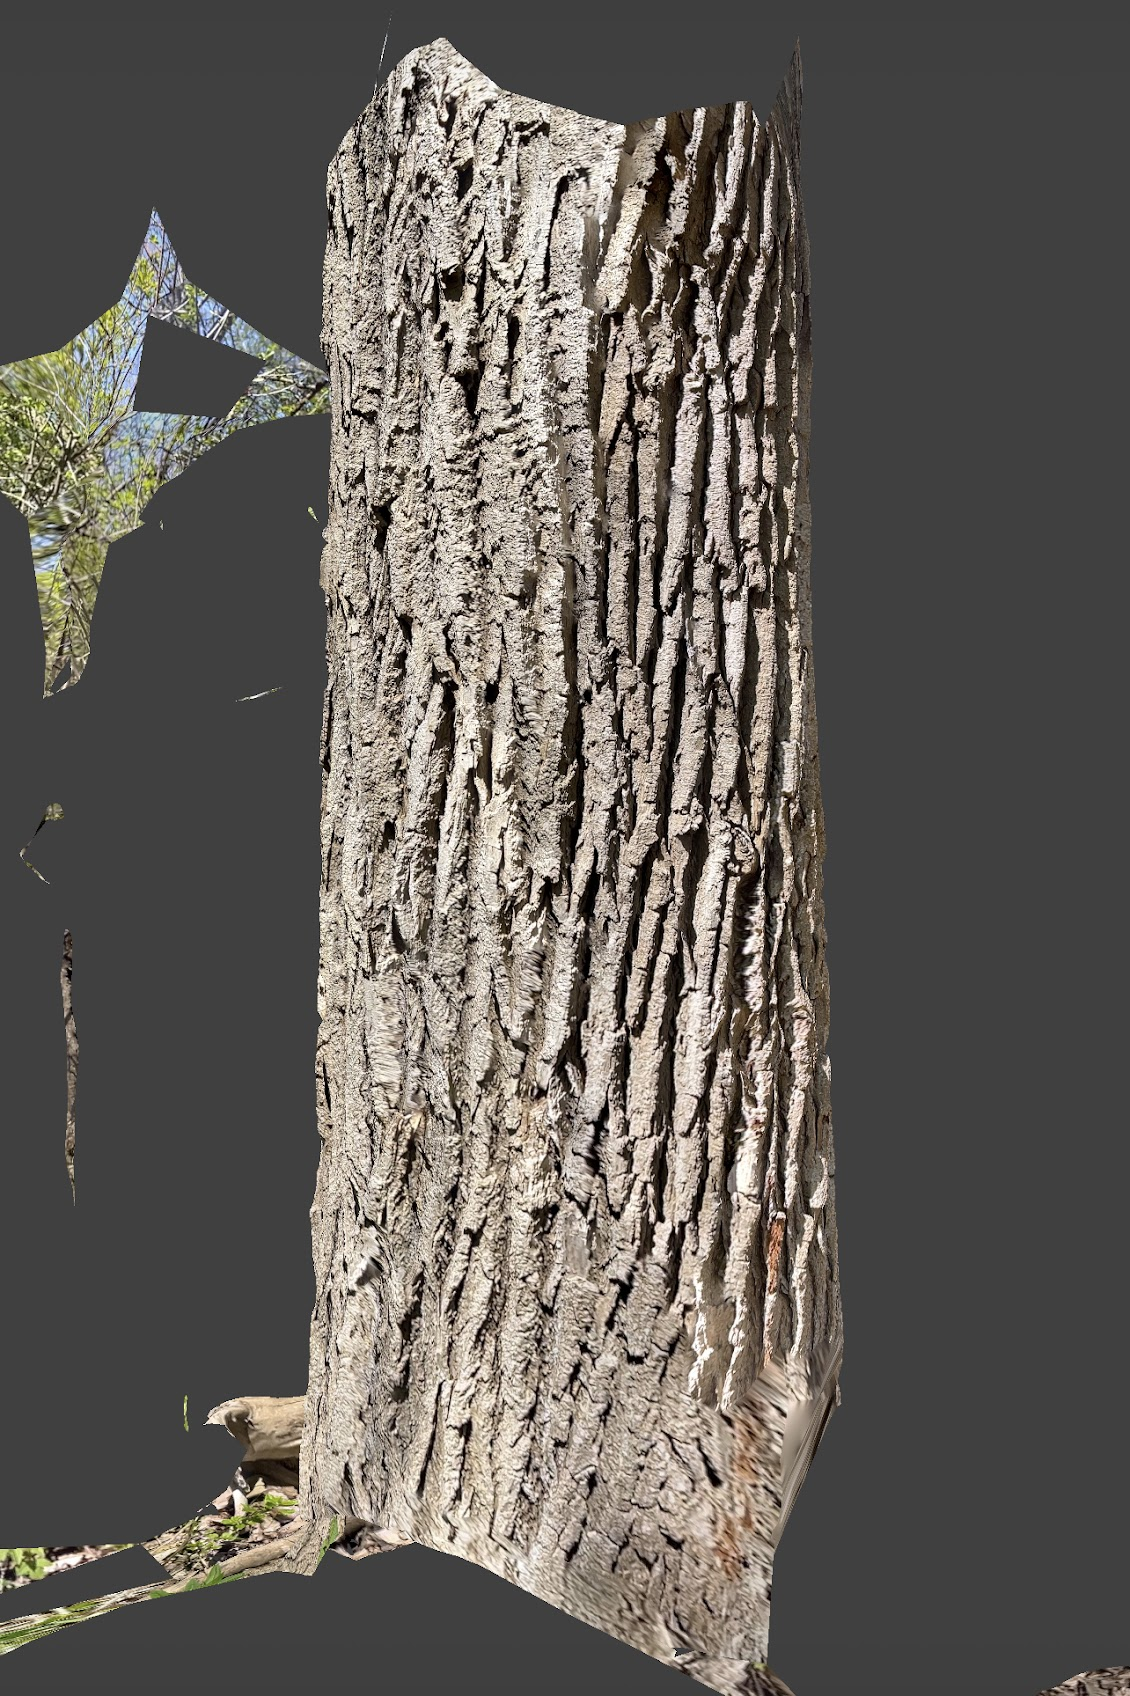

In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import math

# define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
# and p1 being the left hand of the angle
# inputs: three angle points, as tuples
# output: angle in degrees

def angle_between(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

In [2]:
# Path to the STL file
path_to_stl_file = "./tree1.stl"

# Read the STL file using Open3D
mesh = o3d.io.read_triangle_mesh(path_to_stl_file)

# Convert the mesh to a point cloud
pcd = mesh.sample_points_poisson_disk(number_of_points=100000)
pc_arr = np.asarray(pcd.points)

# Print the dimensions of the NumPy array
print(pc_arr.shape)

(100000, 3)


In [3]:
# separate into coordiante values for masking

xvals = pc_arr[:,0]
yvals = pc_arr[:,1]
zvals = pc_arr[:,2]

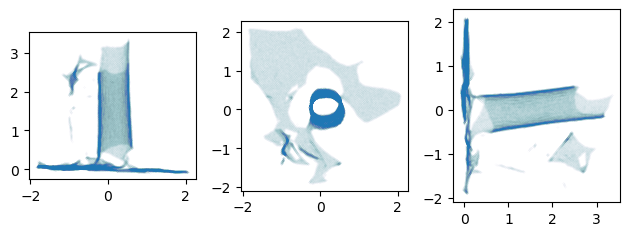

In [4]:
# visualize unmasked data

ps = 0.0001
al = 0.5

plt.subplot(1,3,1)
plt.scatter(xvals, yvals, s=ps, alpha=al)
plt.gca().set_aspect("equal")

plt.subplot(1,3,2)
plt.scatter(xvals, zvals, s=ps, alpha=al)
plt.gca().set_aspect("equal")

plt.subplot(1,3,3)
plt.scatter(yvals, zvals, s=ps, alpha=al)
plt.gca().set_aspect("equal")

plt.tight_layout()

In [5]:
# mask by xvals

xmin = -0.31
xmax = 0.66
xmask = (xvals>xmin) & (xvals<xmax)

xvals_masked = xvals[xmask]
yvals_masked = yvals[xmask]
zvals_masked = zvals[xmask]

In [6]:
# mask by yvals

ymin = 0.75
ymax = 2.25
ymask = (yvals_masked>ymin) & (yvals_masked<ymax)


xvals_masked = xvals_masked[ymask]
yvals_masked = yvals_masked[ymask]
zvals_masked = zvals_masked[ymask]

In [7]:
# mask by zvals

zmin = -0.5
zmask = zvals_masked>zmin

xvals_masked = xvals_masked[zmask]
yvals_masked = yvals_masked[zmask]
zvals_masked = zvals_masked[zmask]

In [8]:
# stack values into a single array and reshape

masked_arr = np.stack((xvals_masked, yvals_masked, zvals_masked), axis=1)


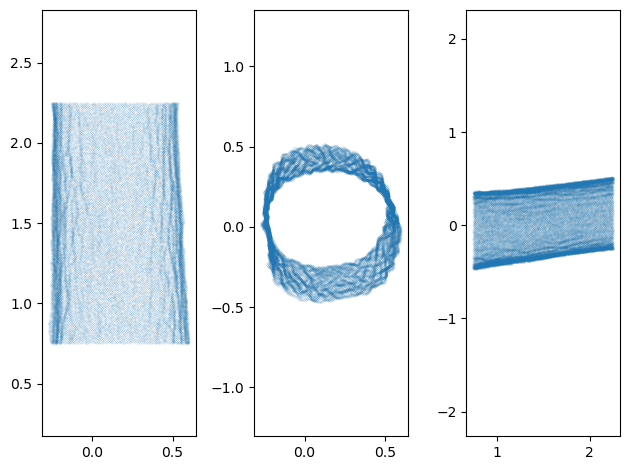

In [9]:
# visualize masked data

ps = 0.01
al = 0.5

plt.subplot(1,3,1)
plt.scatter(masked_arr[:,0], masked_arr[:,1], s=ps, alpha=al)
plt.gca().set_aspect("equal", adjustable="datalim")

plt.subplot(1,3,2)
plt.scatter(masked_arr[:,0], masked_arr[:,2], s=ps, alpha=al)
plt.gca().set_aspect("equal", adjustable="datalim")

plt.subplot(1,3,3)
plt.scatter(masked_arr[:,1], masked_arr[:,2], s=ps, alpha=al)
plt.gca().set_aspect("equal", adjustable="datalim")

plt.tight_layout()

In [10]:
# perform a PCA to orient data along main axis

pca = PCA(n_components=3)

PCs = pca.fit_transform(masked_arr)

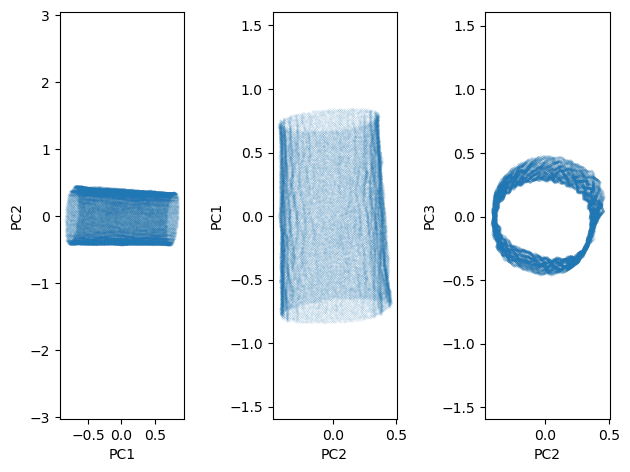

In [11]:
# visualize PC data

ps = 0.01
al = 0.5

plt.subplot(1,3,1)
plt.scatter(PCs[:,0], PCs[:,1], s=ps, alpha=al)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.gca().set_aspect("equal", adjustable="datalim")

plt.subplot(1,3,2)
plt.scatter(PCs[:,1], PCs[:,0], s=ps, alpha=al)
plt.xlabel("PC2")
plt.ylabel("PC1")
plt.gca().set_aspect("equal", adjustable="datalim")

plt.subplot(1,3,3)
plt.scatter(PCs[:,1], PCs[:,2], s=ps, alpha=al)
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.gca().set_aspect("equal", adjustable="datalim")

plt.tight_layout()


In [63]:
# Using PC data, calculate distance and angles of points

pad = 0.1
PC1_vals = PCs[:,0]
PC2_vals = PCs[:,1]
PC3_vals = PCs[:,2]

dist_list = []
ang_list = []

for i in range(len(PCs)):
    
    # get current point
    curr_pt = PCs[i,:]
    
    # find an interval of PC1 vals to calculate PC2 and PC3 means for as a mask
    PC1_mask = (PC1_vals > (curr_pt[0]-pad)) & (PC1_vals < (curr_pt[0]+pad))

    # apply mask to retrieve corresponding PC2 and PC3 values across the interval
    PC2_int = PC2_vals[PC1_mask]
    PC3_int = PC3_vals[PC1_mask]

    # find the center PC2 and PC3 values as a mean
    PC2_center = np.mean(PC2_int)
    PC3_center = np.mean(PC3_int)
    
    # find distance of current point from the center
    dist = np.sqrt( (curr_pt[1]-PC2_center)**2 + (curr_pt[2]-PC3_center)**2)
    dist_list.append(dist)
    
    ang = angle_between((curr_pt[1],curr_pt[2]),
                  (PC2_center,PC3_center),
                  (PC2_center,PC3_center+1))
    ang_list.append(ang)
    
dist_arr = np.array(dist_list)
ang_arr = np.array(ang_list)

PCs_df = pd.DataFrame({"PC1":PCs[:,0],
                       "PC2":PCs[:,1],
                       "PC3":PCs[:,2],
                       "dist":dist_arr,
                       "ang":ang_arr,
                      })

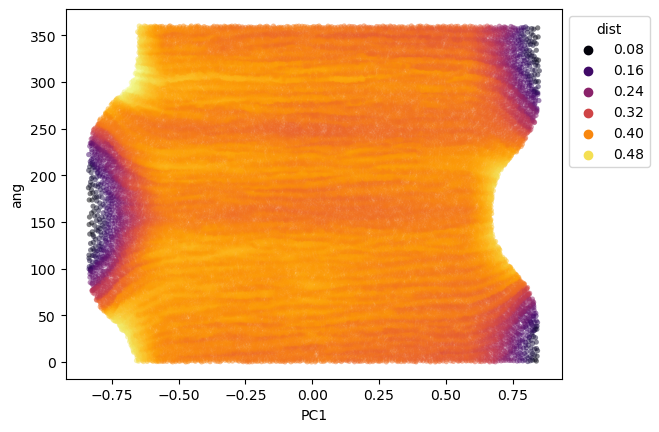

In [64]:
# visualize polar plot of distances of points from main axis

ps = 14
al = 0.5

ax = sns.scatterplot(data=PCs_df, x="PC1", y="ang", hue="dist", s=ps, alpha=al, palette="inferno", linewidth=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [91]:
# recalculate a range of PC1 values to analyze

range_val = 0.5
PC1_vals = PCs[:,0]
PC2_vals = PCs[:,1]
PC3_vals = PCs[:,2]
rangePC1_mask = (PC1_vals > -range_val) & (PC1_vals < range_val)

# apply mask to retrieve corresponding PC values across the interval
rangePC1_vals = PC1_vals[rangePC1_mask]
rangePC2_vals = PC2_vals[rangePC1_mask]
rangePC3_vals = PC3_vals[rangePC1_mask]
rangePCs = np.stack((rangePC1_vals, rangePC2_vals, rangePC3_vals), axis=1)

pad = 0.1
dist_list = []
ang_list = []

for i in range(len(rangePCs)):
    
    # get current point
    curr_pt = rangePCs[i,:]
    
    # find an interval of PC1 vals to calculate PC2 and PC3 means for as a mask
    PC1_mask = (PC1_vals > (curr_pt[0]-pad)) & (PC1_vals < (curr_pt[0]+pad))

    # apply mask to retrieve corresponding PC2 and PC3 values across the interval
    PC2_int = PC2_vals[PC1_mask]
    PC3_int = PC3_vals[PC1_mask]

    # find the center PC2 and PC3 values as a mean
    PC2_center = np.mean(PC2_int)
    PC3_center = np.mean(PC3_int)
    
    # find distance of current point from the center
    dist = np.sqrt( (curr_pt[1]-PC2_center)**2 + (curr_pt[2]-PC3_center)**2)
    dist_list.append(dist)
    
    ang = angle_between((curr_pt[1],curr_pt[2]),
                  (PC2_center,PC3_center),
                  (PC2_center,PC3_center+1))
    ang_list.append(ang)
    
dist_arr = np.array(dist_list)
ang_arr = np.array(ang_list)

rangePCs_df = pd.DataFrame({"PC1":rangePCs[:,0],
                       "PC2":rangePCs[:,1],
                       "PC3":rangePCs[:,2],
                       "dist":dist_arr,
                       "ang":ang_arr,
                      })

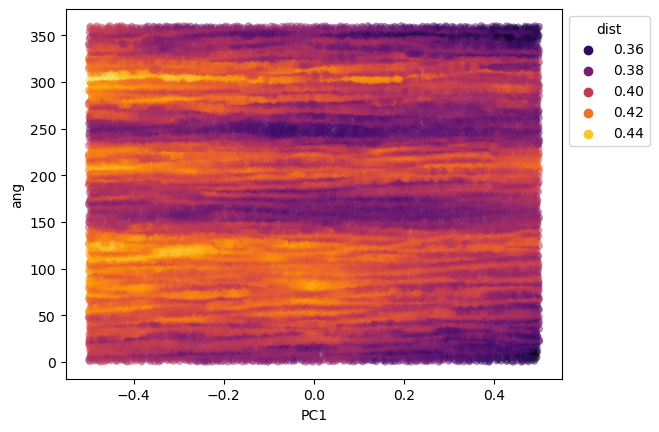

In [93]:
# visualize polar plot of distances of points from main axis

ps = 30
al = 0.5

ax = sns.scatterplot(data=rangePCs_df, x="PC1", y="ang", hue="dist", s=ps, alpha=al, palette="inferno", linewidth=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
